# Определение региона добычи нефти с максимальной прибылью

## Получение и изучение данных

### Поставленная задача и исходные данные

**Заказчик: добывающая компания «ГлавРосГосНефть»**

**Цель**

Нужно решить, где бурить новую скважину.


**Исходные данные**

Предоставлены характеристики для скважин: качество нефти и объём её запасов для трёх регионов.


**Задачи**
- построение модели для предсказания объёма запасов в новых скважинах;
- выбор скважины с самыми высокими оценками значений;
- определение региона с максимальной суммарной прибылью отобранных скважин;
- анализ возможной прибыли и рисков техникой Bootstrap.

**Описание данных**

*Признаки*
- `id` — уникальный идентификатор скважины
- `f0, f1, f2` — три признака точек (неважно, что они означают, но сами признаки значимы)

*Целевой признак*
- `product` — объём запасов в скважине (тыс. баррелей)

**Условия**
- Для обучения модели подходит только `линейная регрессия` (остальные — недостаточно предсказуемые).
- При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
- Бюджет на разработку скважин в регионе — 10 млрд рублей.
- При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
- После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.
- Данные синтетические: детали контрактов и характеристики месторождений не разглашаются.

### Обзор данных

<ins>Импорт библиотек</ins>

In [1]:
import pandas as pd
from pandas.plotting import scatter_matrix

import matplotlib
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_style('darkgrid')
sns.set_palette('Set2')

import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

<ins>Создание классов</ins>

Для удобства вывода на печать создадим классы для работы с текстом

In [2]:
class color:
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'
    END = '\033[0m'

<ins>Чтение файлов с данными</ins>

In [3]:
df_0 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_0.csv')
df_1 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_1.csv')
df_2 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_2.csv')

<ins>Изучение общей информации о данных и внесение корректировок на основе наблюдений</ins>

In [4]:
for df in ['df_0', 'df_1', 'df_2']:
    
    print(f'\n\033[1mДатасет {df}\033[0m\n\n\
Количество явных дубликатов:\
{locals()[df].duplicated().sum()}\n\n\
Количество дубликатов в столбце id: \
{locals()[df].duplicated(subset="id", keep=False).sum()}\n\n\
Количество уникальных значений среди дубликатов в столбце id: \
{locals()[df].duplicated(subset="id").sum()}\n\n\
Процент дубликатов в столбце id ко всем данным в столбце: \
{(locals()[df].duplicated(subset="id", keep=False).sum()/len(locals()[df])):.3%}\n')
    
    display(locals()[df].info(), locals()[df].head(), locals()[df].describe())


Датасет df_0

Количество явных дубликатов:0

Количество дубликатов в столбце id: 20

Количество уникальных значений среди дубликатов в столбце id: 10

Процент дубликатов в столбце id ко всем данным в столбце: 0.020%

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

id        f0        f1        f2     product
0  txEyH  0.705745 -0.497823  1.221170  105.280062
1  2acmU  1.334711 -0.340164  4.365080   73.037750
2  409Wp  1.022732  0.151990  1.419926   85.265647
3  iJLyR -0.032172  0.139033  2.978566  168.620776
4  Xdl7t  1.988431  0.155413  4.751769  154.036647

f0             f1             f2        product
count  100000.000000  100000.000000  100000.000000  100000.000000
mean        0.500419       0.250143       2.502647      92.500000
std         0.871832       0.504433       3.248248      44.288691
min        -1.408605      -0.848218     -12.088328       0.000000
25%        -0.072580      -0.200881       0.287748      56.497507
50%         0.502360       0.250252       2.515969      91.849972
75%         1.073581       0.700646       4.715088     128.564089
max         2.362331       1.343769      16.003790     185.364347


Датасет df_1

Количество явных дубликатов:0

Количество дубликатов в столбце id: 8

Количество уникальных значений среди дубликатов в столбце id: 4

Процент дубликатов в столбце id ко всем данным в столбце: 0.008%

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

id         f0         f1        f2     product
0  kBEdx -15.001348  -8.276000 -0.005876    3.179103
1  62mP7  14.272088  -3.475083  0.999183   26.953261
2  vyE1P   6.263187  -5.948386  5.001160  134.766305
3  KcrkZ -13.081196 -11.506057  4.999415  137.945408
4  AHL4O  12.702195  -8.147433  5.004363  134.766305

f0             f1             f2        product
count  100000.000000  100000.000000  100000.000000  100000.000000
mean        1.141296      -4.796579       2.494541      68.825000
std         8.965932       5.119872       1.703572      45.944423
min       -31.609576     -26.358598      -0.018144       0.000000
25%        -6.298551      -8.267985       1.000021      26.953261
50%         1.153055      -4.813172       2.011479      57.085625
75%         8.621015      -1.332816       3.999904     107.813044
max        29.421755      18.734063       5.019721     137.945408


Датасет df_2

Количество явных дубликатов:0

Количество дубликатов в столбце id: 8

Количество уникальных значений среди дубликатов в столбце id: 4

Процент дубликатов в столбце id ко всем данным в столбце: 0.008%

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

id        f0        f1        f2     product
0  fwXo0 -1.146987  0.963328 -0.828965   27.758673
1  WJtFt  0.262778  0.269839 -2.530187   56.069697
2  ovLUW  0.194587  0.289035 -5.586433   62.871910
3  q6cA6  2.236060 -0.553760  0.930038  114.572842
4  WPMUX -0.515993  1.716266  5.899011  149.600746

f0             f1             f2        product
count  100000.000000  100000.000000  100000.000000  100000.000000
mean        0.002023      -0.002081       2.495128      95.000000
std         1.732045       1.730417       3.473445      44.749921
min        -8.760004      -7.084020     -11.970335       0.000000
25%        -1.162288      -1.174820       0.130359      59.450441
50%         0.009424      -0.009482       2.484236      94.925613
75%         1.158535       1.163678       4.858794     130.595027
max         7.238262       7.844801      16.739402     190.029838

Наблюдения:
- столбец `id` содержит дубликаты, процент которых довольно низкий
- столбец `id` нечисловой, обучить по нему регрессию невозможно
- наименования столбцов приведены к "змеиному" регистру
- пропуски отсутствуют

Т.к. столбец `id` (уникальный идентификатор скважины) не имеет отношения к поставленным задачам, то его требуется удалить.

Перед удалением посмотрим на повторяющиеся данные в этом столбце.

In [5]:
for df in ['df_0', 'df_1', 'df_2']:    
    print(f'\n\033[1mДатасет {df}\033[0m')
    display(locals()[df].loc[locals()[df].duplicated(subset='id', keep=False)].sort_values(by='id'))


Датасет df_0


id        f0        f1         f2     product
66136  74z30  1.084962 -0.312358   6.990771  127.643327
64022  74z30  0.741456  0.459229   5.153109  140.771492
51970  A5aEY -0.180335  0.935548  -2.094773   33.020205
3389   A5aEY -0.039949  0.156872   0.209861   89.249364
69163  AGS9W -0.933795  0.116194  -3.655896   19.230453
42529  AGS9W  1.454747 -0.479651   0.683380  126.370504
931    HZww2  0.755284  0.368511   1.863211   30.681774
7530   HZww2  1.061194 -0.373969  10.430210  158.828695
63593  QcMuo  0.635635 -0.473422   0.862670   64.578675
1949   QcMuo  0.506563 -0.323775  -2.215583   75.496502
75715  Tdehs  0.112079  0.430296   3.218993   60.964018
21426  Tdehs  0.829407  0.298807  -0.049563   96.035308
92341  TtcGQ  0.110711  1.022689   0.911381  101.318008
60140  TtcGQ  0.569276 -0.104876   6.440215   85.350186
89582  bsk9y  0.398908 -0.400253  10.122376  163.433078
97785  bsk9y  0.378429  0.005837   0.160827  160.637302
41724  bxg6G -0.823752  0.546319   3.630479   93.007798
1364   bxg6G  0.411645  0.856830  -3.653440   73.604260
16633  fiKDv  0.157341  1.028359   5.585586   95.817889
90815  fiKDv  0.049883  0.841313   6.394613  137.346586


Датасет df_1


id         f0         f1        f2     product
5849   5ltQ6  -3.435401 -12.296043  1.999796   57.085625
84461  5ltQ6  18.213839   2.191999  3.993869  107.813044
1305   LHZR0  11.170835  -1.945066  3.002872   80.859783
41906  LHZR0  -8.989672  -4.286607  2.009139   57.085625
2721   bfPNe  -9.494442  -5.463692  4.006042  110.992147
82178  bfPNe  -6.202799  -4.820045  2.995107   84.038886
47591  wt4Uk  -9.091098  -8.109279 -0.002314    3.179103
82873  wt4Uk  10.259972  -9.376355  4.994297  134.766305


Датасет df_2


id        f0        f1        f2     product
45404  KUPhW  0.231846 -1.698941  4.990775   11.716299
55967  KUPhW  1.211150  3.176408  5.543540  132.831802
11449  VF7Jo  2.122656 -0.858275  5.746001  181.716817
49564  VF7Jo -0.883115  0.560537  0.723601  136.233420
44378  Vcm5J -1.229484 -2.439204  1.222909  137.968290
95090  Vcm5J  2.587702  1.986875  2.482245   92.327572
28039  xCHr8  1.633027  0.368135 -2.378367    6.120525
43233  xCHr8 -0.847066  2.101796  5.597130  184.388641

В дубликатах одинаковые по `id` скважины имеют разные параметры. Скорее всего, здесь ошибка заполнения данных.

Т.к. процент дубликатов в столбце `id` низкий удалим неадекватные данные (строки с дубликатами), предварительно согласовав этот момент с заказчиком.

In [6]:
for df in ['df_0', 'df_1', 'df_2']:   
    locals()[df].drop_duplicates(subset='id', keep=False, inplace=True)
    print(f'\n\033[1mДатасет {df}\033[0m\n\
Количество дубликатов в столбце id: \
{locals()[df].duplicated(subset="id", keep=False).sum()}')


Датасет df_0
Количество дубликатов в столбце id: 0

Датасет df_1
Количество дубликатов в столбце id: 0

Датасет df_2
Количество дубликатов в столбце id: 0


Теперь удалим столбец `id`

In [7]:
for df in [df_0, df_1, df_2]:   
    df.drop('id', axis=1, inplace=True)

Посмотрим, как признаки коррелируют между собой

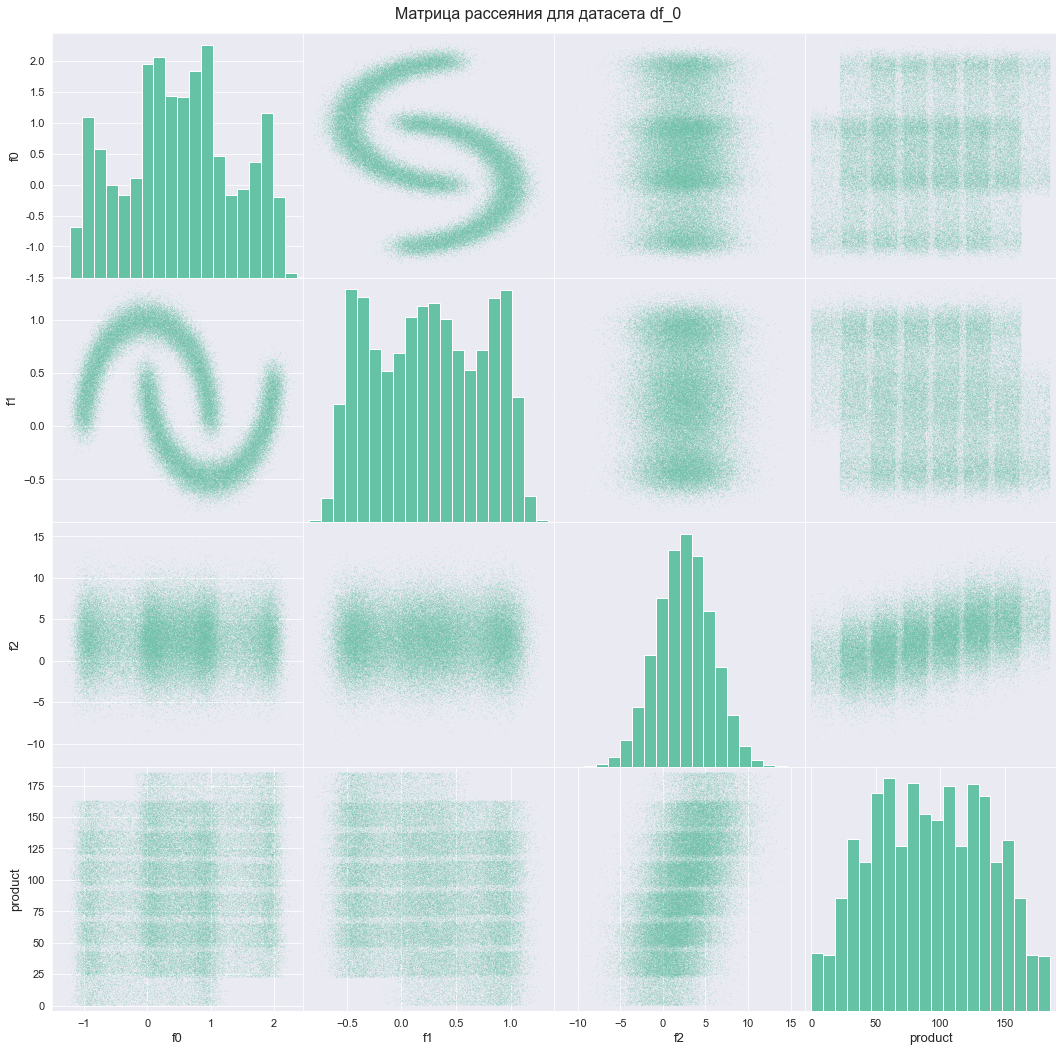

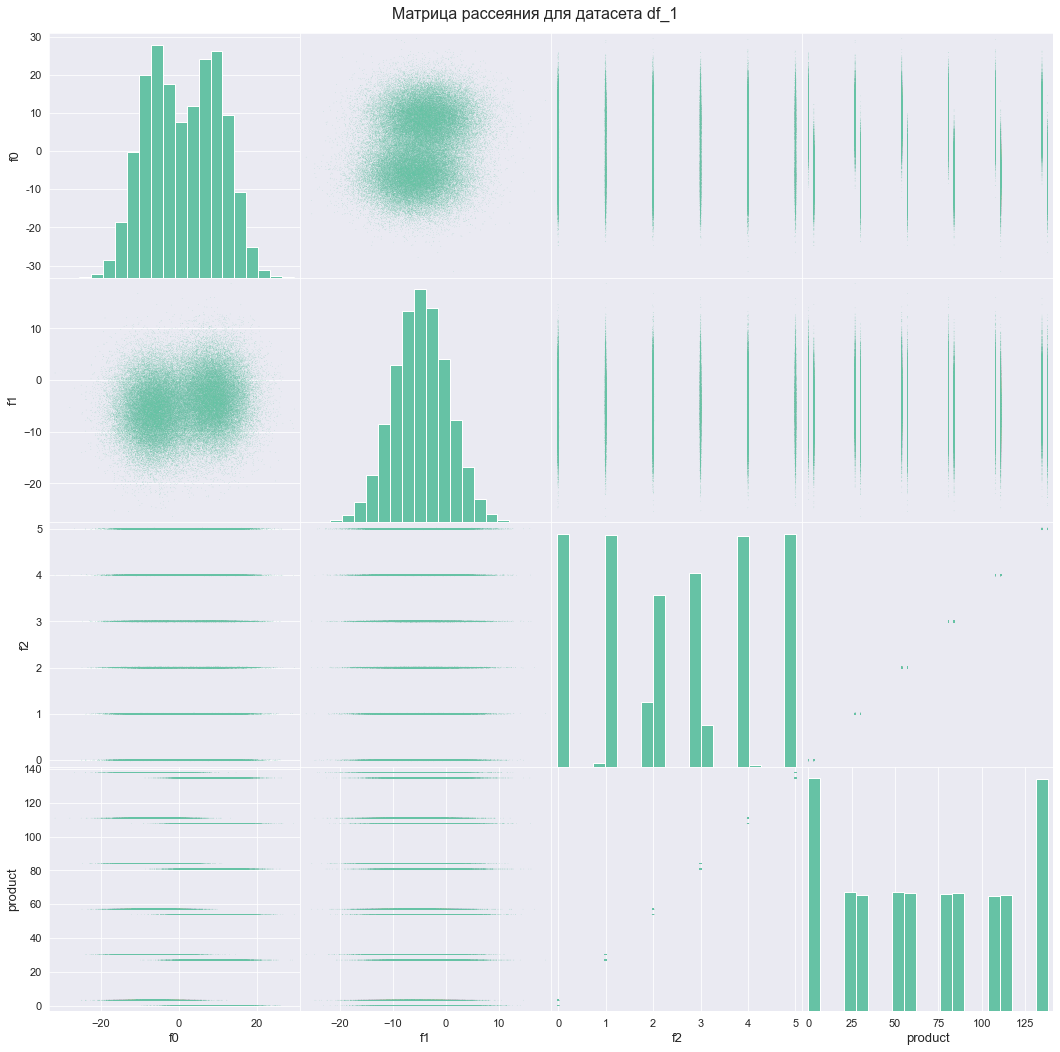

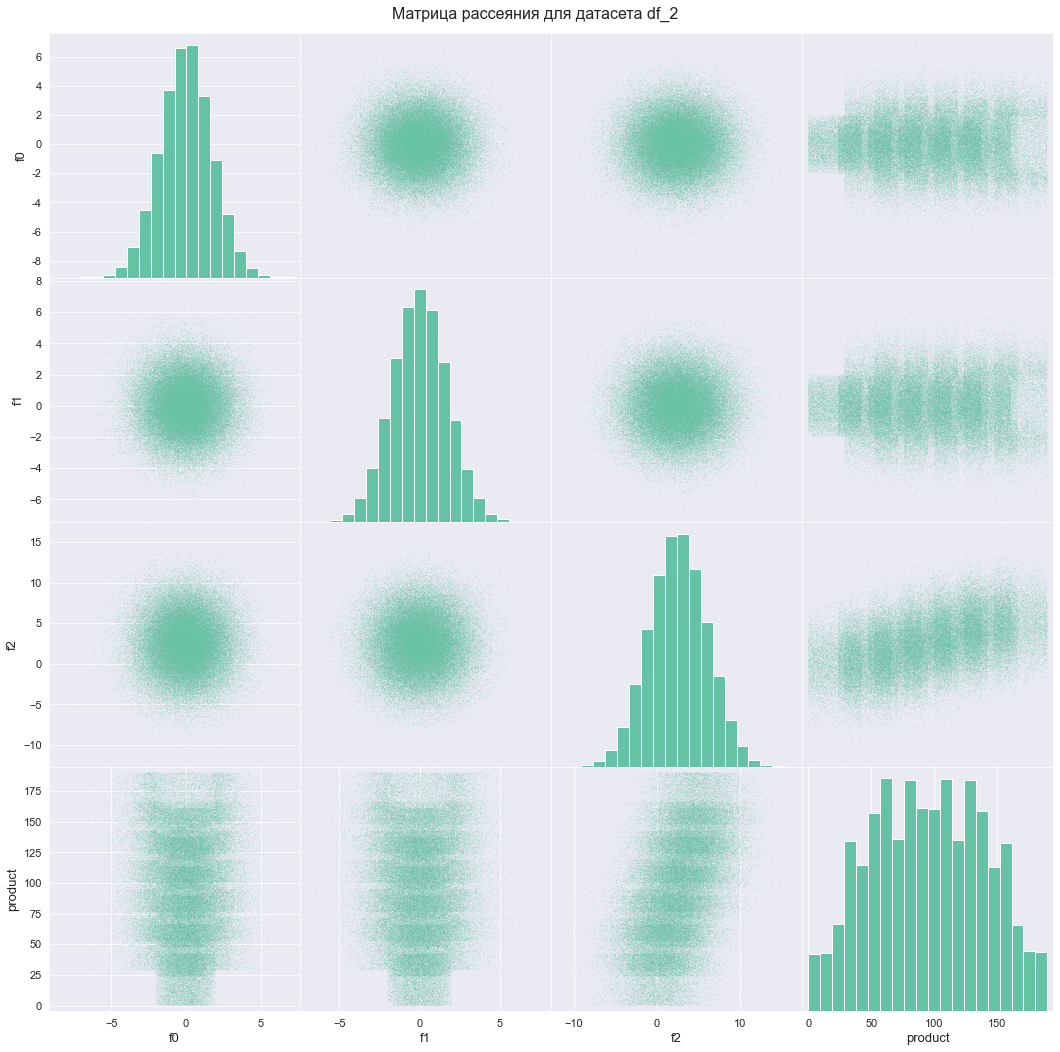

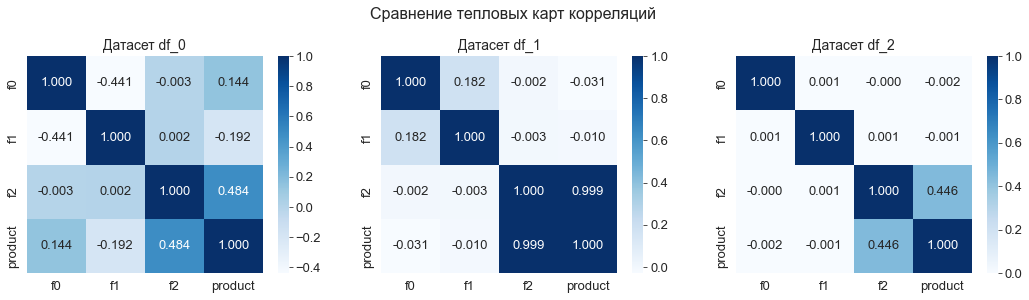

In [8]:
for i, df in enumerate([df_0, df_1, df_2]):     
    smatrix=scatter_matrix(df,
                           alpha=0.7,
                           s=1,
                           figsize=(18, 18),
                           diagonal='hist',
                           hist_kwds={'bins':20})
    plt.suptitle(f'Матрица рассеяния для датасета df_{i}', y=.9, fontsize = 16)
    
    for item in smatrix.ravel():
        plt.setp(item.yaxis.get_majorticklabels(), 'size', 11)
        plt.setp(item.xaxis.get_majorticklabels(), 'size', 11, rotation=0)
        plt.setp(item.yaxis.get_label(), 'size', 13)
        plt.setp(item.xaxis.get_label(), 'size', 13)

plt.rcParams['font.size'] = '13'
fig, ax = plt.subplots(1,3,figsize=(18,4))

fig.suptitle('Сравнение тепловых карт корреляций', y = 1.05, fontsize = 16)

for i, df in enumerate([df_0, df_1, df_2]):    
    sns.heatmap(df.corr(), annot=True, annot_kws={"size": 13}, fmt= '.3f', ax=ax[i], cmap="Blues")
    ax[i].set_title(f'Датасет df_{i}', fontsize = 14);

<center>Распределение данных</center>

| **Датасет df_0** | **Датасет df_1** | **Датасет df_2** |
| :--- | :--- | :--- |
|`f0` - нормальное распределение|`f0` - нормальное распределение|`f0` - нормальное распределение|
|`f1` - нормальное распределение|`f1` - нормальное распределение|`f1` - нормальное распределение|
|`f2` - нормальное распределение|`f2` - распределение с пиками<br>в крайних значениях<br>и ярковыраженным шагом|`f2` - нормальное распределение|
|`product` - нормальное распределение|`product` - распределение с пиками<br>в крайних значениях<br>и ярковыраженным шагом|`product` - нормальное распределение|


<br>
<center>Зависимости в данных</center>

| **Корреляция признаков с целевым признаком** | **Корреляция признаков между собой**  |
| :--- | :--- |
|*Датасет df_0:*|*Датасет df_0:*|
| `f0`vs`product` - низкая положительная | `f0`vs`f1` - средняя положительная |
| `f1`vs`product` - низкая отрицательная | `f0`vs`f2` - корреляция почти отсутствует |
| `f2`vs`product` - средняя положительная | `f1`vs`f2` - корреляция почти отсутствует |
|*Датасет df_1:*|*Датасет df_1:*|
| `f0`vs`product` - корреляция почти отсутствует | `f0`vs`f1` - низкая положительная |
| `f1`vs`product` - корреляция почти отсутствует | `f0`vs`f2` - корреляция почти отсутствует |
| `f2`vs`product` - высокая положительная | `f1`vs`f2` - корреляция почти отсутствует |
|*Датасет df_2:*|*Датасет df_2:*|
| `f0`vs`product` - корреляция почти отсутствует | `f0`vs`f1` - корреляция почти отсутствует |
| `f1`vs`product` - корреляция почти отсутствует | `f0`vs`f2` - корреляция почти отсутствует |
| `f2`vs`product` - средняя положительная | `f1`vs`f2` - корреляция почти отсутствует |

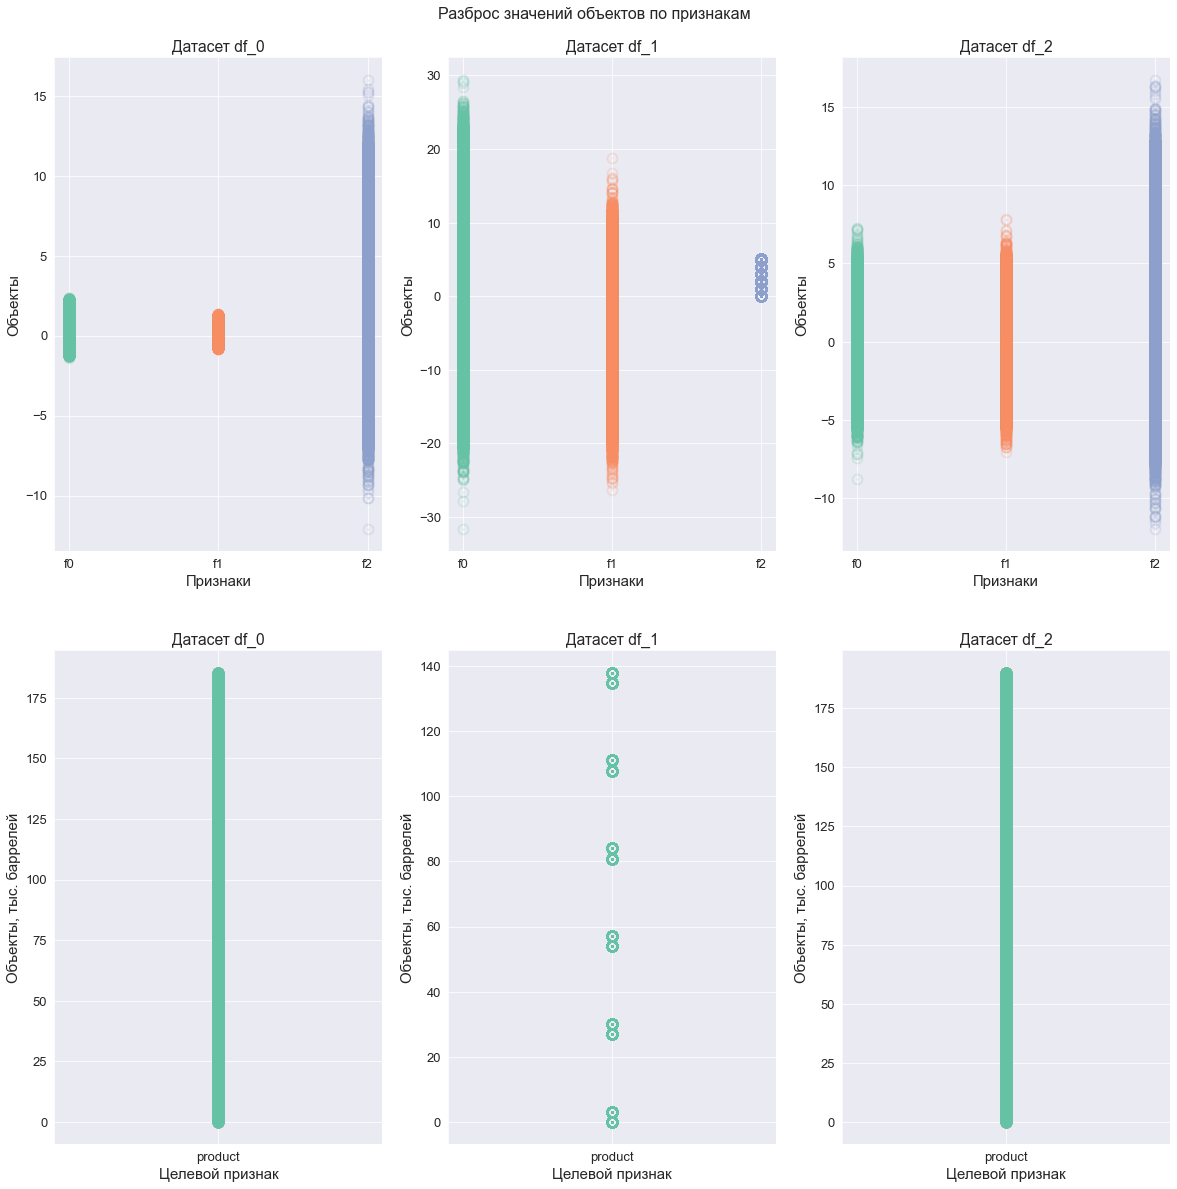

In [9]:
fig, ax = plt.subplots(2, 3, figsize=(20,20))
fig.suptitle('Разброс значений объектов по признакам', y = .915, fontsize = 16)
plt.rcParams['font.size'] = '13'

for i, df in enumerate([df_0, df_1, df_2]):
    for column in list(df.loc[:,'f0':'f2'].columns):
        ax[0,i].scatter([column]*len(df), df[column], alpha=.2, linewidth=10, s = 3)
        ax[0,i].set_xlabel('Признаки', fontsize=15)
        ax[0,i].set_ylabel('Объекты', fontsize=15)
        ax[0,i].title.set_text(f'Датасет df_{i}')
    ax[1,i].scatter(['product']*len(df), df['product'], alpha=.2, linewidth=10, s = 3)
    ax[1,i].set_xlabel('Целевой признак', fontsize=15)
    ax[1,i].set_ylabel('Объекты, тыс. баррелей', fontsize=15)
    ax[1,i].title.set_text(f'Датасет df_{i}')

In [10]:
print(f'Количество уникальных значений в целевом признаке датасета df_1: {df_1["product"].nunique()}')

Количество уникальных значений в целевом признаке датасета df_1: 12


| <font size="4"><center>Наблюдения</center></font> |
| :--- |
|<font size="3">Разброс значений объектов для <ins>признаков</ins> всех трёх датасетов отличается. Среди всех выделяется регион датасета `df_1`. Необходимо выполнить масштабирование|
|<font size="3">Разброс значений объектов для <ins>целевого признака</ins> у `df_0` и `df_2` схож. |
|<font size="3">В датасете `df_1` наблюдается значительно меньшее количество значений в <ins>целевом признаке</ins>, это видно визуально - 12 шт, сгруппированных по 2 с фиксированным шагом. Предполагаю, что в данном регионе в скважине использовалась иная технология добычи, при которой производительность фиксированная, либо для измерения объёма запасов служит система, выдающая дискретные значения, а не аналоговые, как в других регионах. |
|<font size="3">По полученной в исследовательском анализе информации кажется, что модель для `df_1` будет легче обучить из-за меньшего количества объектов в <ins>целевом признаке</ins>. |

## Обучение и проверка моделей для каждого региона

---

Т.к. целевой признак количественный, то необходима модель регрессии.

По исходным данным требуется:
- обучить модель `линейной регрессии`,
- вычислить `средний` запас предсказанного сырья
- вычислить `RMSE` модели

`MSE` *(средняя квадратичная ошибка, от англ. mean squared error)* и `RMSE` *(англ. root mean squared error, «корень из средней квадратичной ошибки»)* показывают, как сильно правильный ответ отличается от предсказания.

Формула расчёта `MSE` выглядит так: $MSE={\frac 1N}{\sum_{i=1}^N(предсказание\,модели-правильный\,ответ)^2}$

Формула расчёта `RMSE` выглядит так: $RMSE=\sqrt[]{{\frac 1N}{\sum_{i=1}^N(предсказание\,модели-правильный\,ответ)^2}}$

*Величина `RMSE` должна быть как можно меньше.*

Чтобы оценить адекватность модели регрессии нужно для сравнения отвечать на все объекты одним и тем же числом, чтобы оно не сильно расходилось с правдой, примем за такое число среднее значение объёма запасов в скважине. Качество модели с такими ответами (константной модели) должно быть хуже, чем качество обученной модели. Сравним `RMSE` обученной модели и константной модели.

Дополнительно посчитаем коэффициент детерминации - метрику `R2` (англ. coefficient of determination; R-squared), она вычисляет долю средней квадратичной ошибки модели от `MSE` среднего, а затем вычитает эту величину из единицы. Увеличение метрики означает прирост качества модели.

Формула расчёта `R2` выглядит так: $R2 = 1-\frac{MSE модели}{MSE среднего}$

- Значение метрики R2 равно единице только в одном случае, если MSE нулевое. Такая модель предсказывает все ответы идеально.
- R2 равно нулю: модель работает так же, как и среднее.
- Если метрика R2 отрицательна, качество модели очень низкое.
- Значения R2 больше единицы быть не может.

Дополнительно посчитаем `MAE` (среднее абсолютное отклонение, от англ. mean absolute error).

Формула расчёта `MAE` выглядит так: $MAE={\frac 1N}{\sum_{i=1}^N|правильный\,ответ-предсказание\,модели|}$

Качество модели определяется минимальным значением `MAE`.

---

Т.к. операции будут повторяться, создадим функцию `model_metrics()`,

принимающую на вход:
- `df` - датафрейм соответствующего региона
- `name` - имя региона

Функция выполняет следующие шаги.
1. Деление на обучающую и валидационную выборки в соотношении 75:25.
2. Проверка результатов деления на выборки.
3. Масштабирование признаков.
4. Обучение модели, предсказания на валидационной выборке, вывод метрик.
5. Визуализация сравнения предсказаний c правильными ответами.

На выходе функции:
- `target_valid` - правильные ответы на валидационной выборке
- `predicted_valid` - предсказания на валидационной выборке
- `metrics` - метрики модели, сведенные в датасет
- `marks_valid` - целевой признак и предсказания валидационной выборки, сведенные в датасет

Датасет `metrics`:
- `region` - имя региона
- `mean_pred` - средний запас предсказанного сырья
- `rmse` - RMSE - корень из средней квадратичной ошибки обученной модели
- `rmse_const` - RMSE - корень из средней квадратичной ошибки константной модели
- `sanity` - вменяемость модели (**True** - вменяема, **False** - нет)
- `r2` - R2 - коэффициент детерминации
- `mae` - MAE - среднее абсолютное отклонение

Датасет `marks_valid`:
- `target_valid` - целевое значение объема сырья для валидационной выборки
- `predicted_valid` - предсказанное значение объема сырья для валидационной выборки

In [11]:
def model_metrics(df: pd.DataFrame, name: str):
    
    '''Деление на обучающую и валидационную выборки в соотношении 75:25'''
    
    target = df['product']
    features = df.drop(['product'] , axis=1)
    features_train, features_valid, target_train, target_valid = train_test_split(features,
                                                                                  target,
                                                                                  test_size=.25,
                                                                                  random_state=12345)
       
    '''Проверка результатов деления на выборки'''
    
    print(color.BOLD+color.UNDERLINE+'Проверка результатов деления на выборки\n'+color.END)
    for col in ['features_train', 'target_train', 'features_valid', 'target_valid']:
        print(f'размер выборки {col} : {locals()[col].shape}')
    
   
    selections = pd.Series({'обучающая': len(target_train),
                            'валидационная': len(target_valid)})
    
    fig = plt.figure(figsize=(10, 4))
    
    pie_selections=selections.plot(kind='pie',
                                   label='',
                                   autopct='%1.0f%%',
                                   title='Долевое соотношение\nразмеров выборок',
                                   shadow=True,
                                   wedgeprops={'lw':1, 'ls':'-','edgecolor':"k"},
                                   colors = ['lightseagreen', 'hotpink', 'gold'],
                                   fontsize=13)
    pie_selections.title.set_size(15)
    
    '''Масштабирование признаков'''
    
    numeric = list(features.columns)
    
    scaler = StandardScaler()
    scaler.fit(features_train[numeric])
    features_train[numeric] = scaler.transform(features_train[numeric])
    features_valid[numeric] = scaler.transform(features_valid[numeric])
    
    fig, ax = plt.subplots(1, 2, figsize=(20,10))
    fig.suptitle('Проверка результата масштабирования - разброс значений объектов по признакам', y = .96, fontsize = 16)
    plt.rcParams['font.size'] = '13'
    
    for i, sel in enumerate(['features_train', 'features_valid']):
        for column in list(locals()[sel].columns):
            ax[i].scatter([column]*len(locals()[sel]), locals()[sel][column], alpha=.2, linewidth=10, s = 3)
            ax[i].set_xlabel('Признаки', fontsize=15)
            ax[i].set_ylabel('Объекты', fontsize=15)
            ax[i].title.set_text(f'выборка {sel}')

    '''Обучение модели, предсказания на валидационной выборке, вывод метрик'''
    
    model = LinearRegression() # инициализация модели
    model.fit(features_train, target_train) # обучение модели
    predicted_valid = model.predict(features_valid) # предсказания модели на валидационной выборке
    predicted_const = pd.Series(target_train.mean(), index=target_valid.index) # предсказания модели на константной выборке        

    metrics = pd.DataFrame({'region': [name],
                            'mean_pred': [predicted_valid.mean().round(3)],
                            'rmse':[(mean_squared_error(target_valid, predicted_valid) ** 0.5).round(3)],
                            'rmse_const':[(mean_squared_error(target_valid, predicted_const) ** 0.5).round(3)],
                            'sanity':[mean_squared_error(target_valid, predicted_valid) ** 0.5
                                      < mean_squared_error(target_valid, predicted_const) ** 0.5],
                            'r2':[r2_score(target_valid, predicted_valid).round(3)],
                            'mae':[mean_absolute_error(target_valid, predicted_valid).round(3)]})
    
    marks_valid = pd.DataFrame({'target_valid': target_valid.reset_index(drop=True),
                                'predicted_valid': predicted_valid})

    '''Визуализация сравнения предсказаний c правильными ответами'''
    
    behavior = sns.jointplot(kind='reg',
                             data=marks_valid,
                             x='target_valid',
                             y='predicted_valid',
                             height=11,
                             space=.02,
                             ratio=2,
                             joint_kws = {'scatter_kws':dict(alpha=0.2)})
    behavior.fig.suptitle('Сравнение предсказаний c правильными ответами', y=1.01, fontsize=13.5);
    
    '''Определение параметров на выходе функции'''   
    
    return target_valid, pd.Series(predicted_valid), metrics, marks_valid

### Регион 0 

Проверка результатов деления на выборки

размер выборки features_train : (74985, 3)
размер выборки target_train : (74985,)
размер выборки features_valid : (24995, 3)
размер выборки target_valid : (24995,)


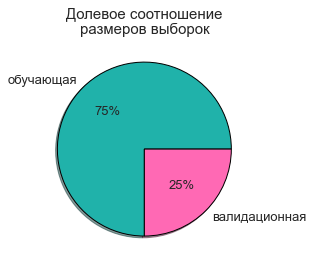

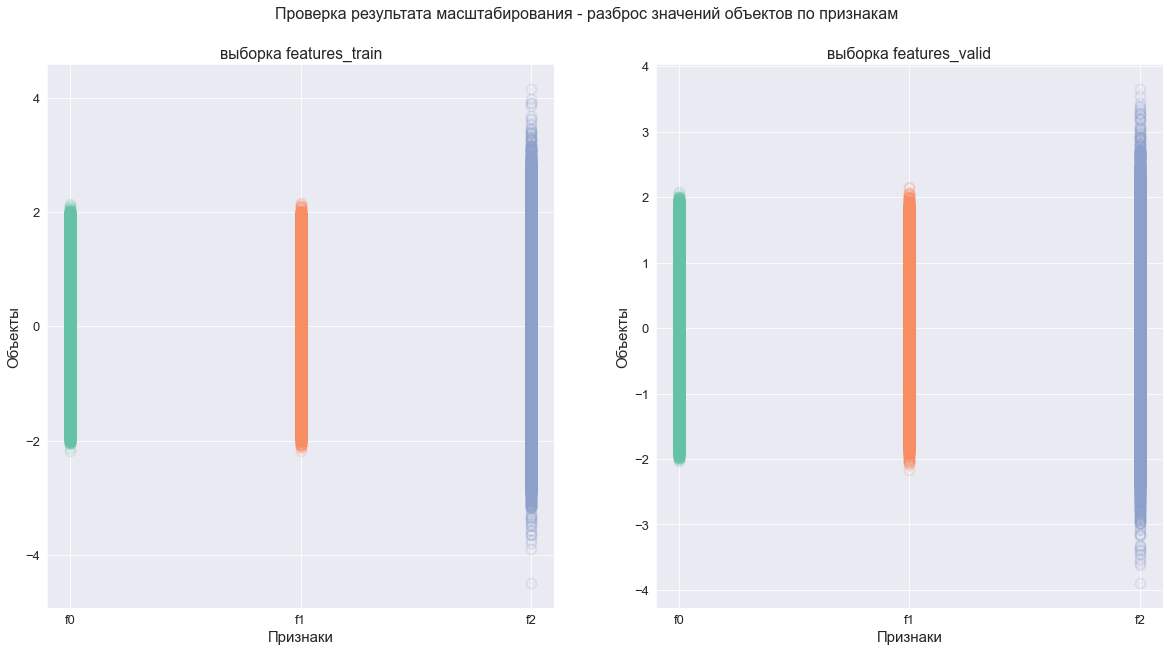

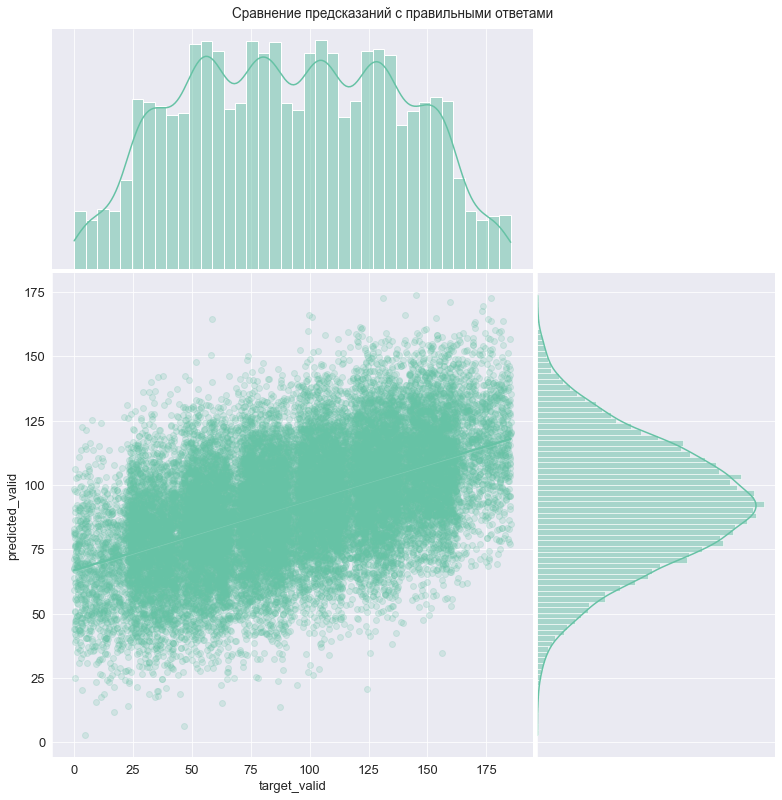

In [12]:
target_valid_0, predicted_valid_0, metrics_0, marks_valid_0 = model_metrics(df_0, 'reg_0')

In [13]:
print(color.BOLD+color.UNDERLINE+'Метрики модели'+color.END)
metrics_0.set_index('region')

Метрики модели


mean_pred    rmse  rmse_const  sanity     r2     mae
region                                                      
reg_0      92.424  37.717      44.347    True  0.277  31.109

### Регион 1 

Проверка результатов деления на выборки

размер выборки features_train : (74994, 3)
размер выборки target_train : (74994,)
размер выборки features_valid : (24998, 3)
размер выборки target_valid : (24998,)


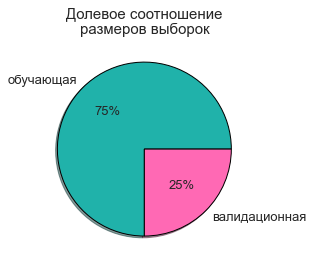

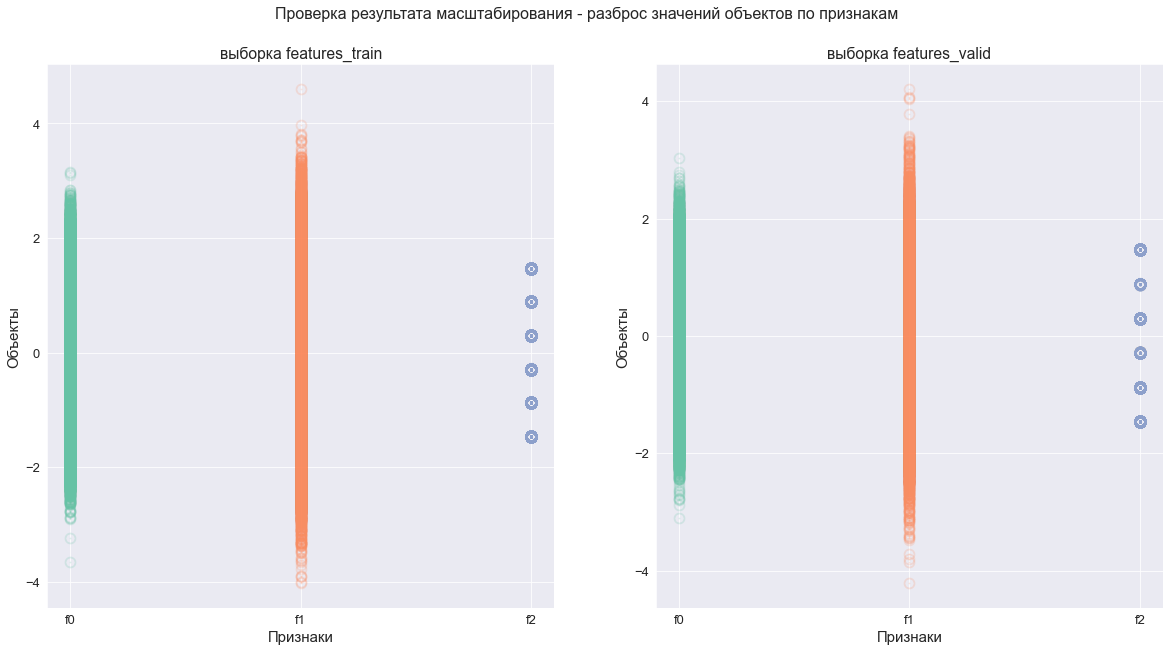

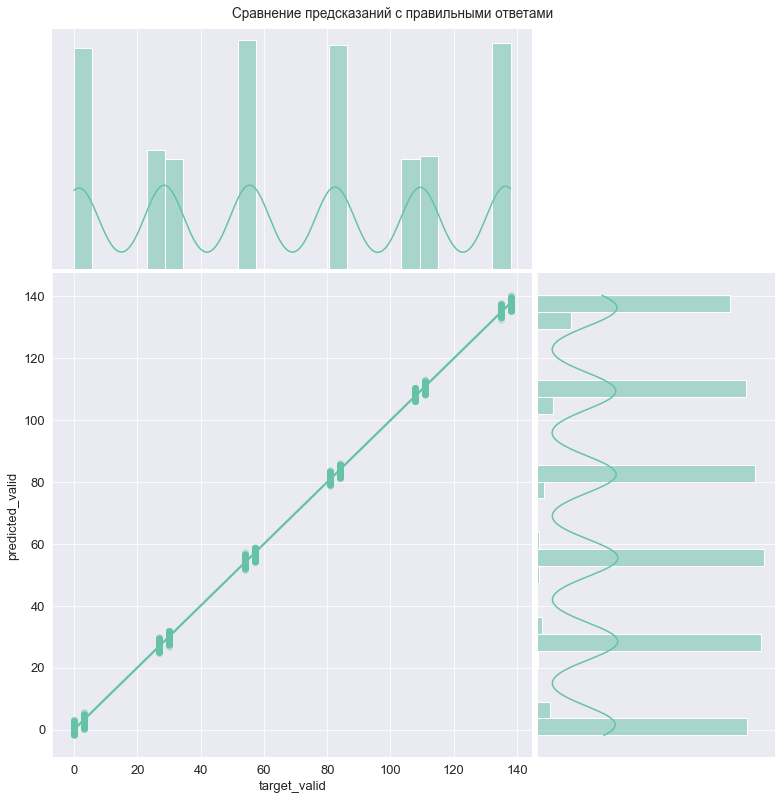

In [14]:
target_valid_1, predicted_valid_1, metrics_1, marks_valid_1 = model_metrics(df_1, 'reg_1')

In [15]:
print(color.BOLD+color.UNDERLINE+'Метрики модели'+color.END)
metrics_1.set_index('region')

Метрики модели


mean_pred   rmse  rmse_const  sanity   r2    mae
region                                                  
reg_1      68.983  0.891       45.97    True  1.0  0.718

### Регион 2 

Проверка результатов деления на выборки

размер выборки features_train : (74994, 3)
размер выборки target_train : (74994,)
размер выборки features_valid : (24998, 3)
размер выборки target_valid : (24998,)


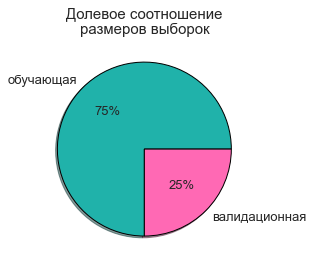

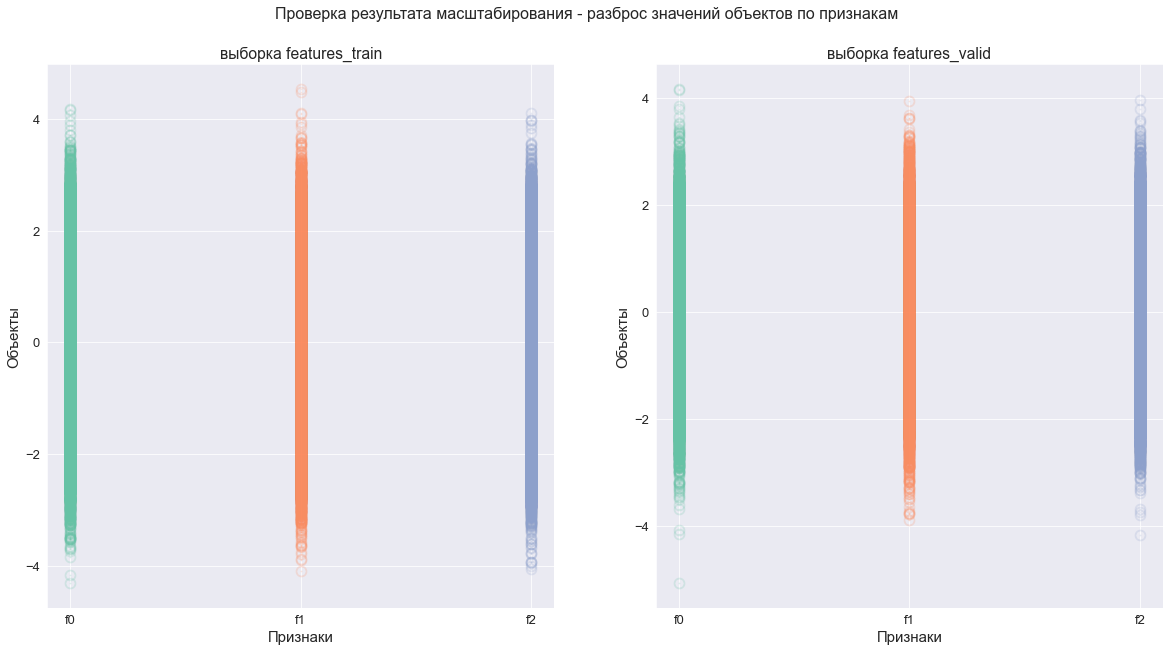

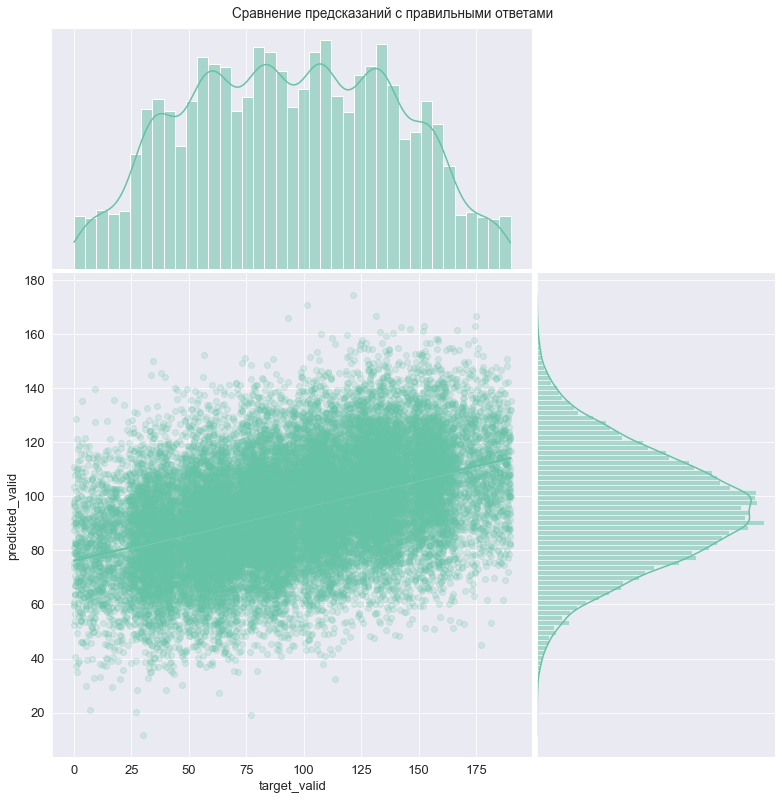

In [16]:
target_valid_2, predicted_valid_2, metrics_2, marks_valid_2 = model_metrics(df_2, 'reg_2')

In [17]:
print(color.BOLD+color.UNDERLINE+'Метрики модели'+color.END)
metrics_2.set_index('region')

Метрики модели


mean_pred    rmse  rmse_const  sanity     r2     mae
region                                                      
reg_2      95.116  39.976      44.575    True  0.196  32.777

### Сравнение результатов

Сведем полученные ранее метрики для всех регионов в один датасет

In [18]:
compare_metrics = (metrics_0.merge(metrics_1, on=list(metrics_0.columns), how='outer')
                            .merge(metrics_2, on=list(metrics_0.columns), how='outer'))
compare_metrics.set_index('region')

mean_pred    rmse  rmse_const  sanity     r2     mae
region                                                      
reg_0      92.424  37.717      44.347    True  0.277  31.109
reg_1      68.983   0.891      45.970    True  1.000   0.718
reg_2      95.116  39.976      44.575    True  0.196  32.777

Сравним тепловые карты качества моделей регионов

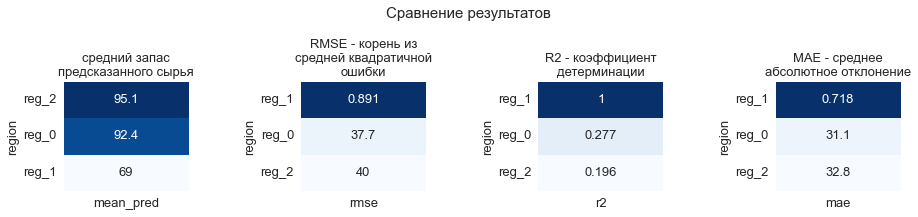

In [19]:
metrics_list = ['mean_pred', 'rmse', 'r2', 'mae']
ax_list = ['ax1', 'ax2', 'ax3', 'ax4']
title_list = ['средний запас\nпредсказанного сырья',
              'RMSE - корень из\nсредней квадратичной\nошибки',
              'R2 - коэффициент\nдетерминации',
              'MAE - среднее\nабсолютное отклонение']

fig, (ax1,ax2,ax3,ax4) = plt.subplots(ncols=4, figsize=(15,2))
fig.subplots_adjust(wspace=0.9)
fig.suptitle('Сравнение результатов', y = 1.4, fontsize = 15)

for i in range(4):
    if metrics_list[i] == 'mean_pred' or metrics_list[i] == 'r2':
        sns.heatmap(
            compare_metrics[['region', metrics_list[i]]].set_index('region').sort_values(by=metrics_list[i], ascending=False),
            ax=locals()[ax_list[i]],
            cbar=False,
            cmap="Blues",
            annot=True,
            fmt ='.3g',
            annot_kws={'size':13});
    else: 
        sns.heatmap(
            compare_metrics[['region', metrics_list[i]]].set_index('region').sort_values(by=metrics_list[i]),
            ax=locals()[ax_list[i]],
            cbar=False,
            cmap="Blues_r",
            annot=True,
            fmt ='.3g',
            annot_kws={'size':13});
    
    locals()[ax_list[i]].tick_params(rotation=0)
    locals()[ax_list[i]].set_title(title_list[i], fontsize=13);

- Лучшее качество у региона `reg_1`, показатели качества моделей для других регионов схожи и значительно уступают.
- Средний запас сырья в регионах `reg_2` и `reg_0` схож около 90 тыс. баррелей, в регионе `reg_1` значительно ниже, примерно на 30%.
- Скорее всего на показатели качества влияют:
    - выбранная модель,
    - вид распределения данных (нормальное либо отличное от нормального),
    - количество уникальных значений в целевом признаке,
    - высокая корреляция признаков с целевым признаком.

## Подготовка к расчёту прибыли

### Создание переменных для ключевых значений

In [20]:
points = 500                 # количество точек исследования
best_points = 200            # количество точек разработки
budget = 10 ** 10            # бюджет на разработку, руб
revenue_barrel = 450         # доход с одного барреля сырья, руб
revenue_product = 450_000    # доход с каждой единицы продукта, руб

### Рассчёт объёма сырья, достаточного для безубыточной разработки новой скважины

Объём сырья, достаточный для безубыточной разработки новой скважины, расчитаем по формуле:

$\large{product_{plus} = \Large{budget\over revenue_{product} \cdot best_{points}}}\small, (тыс. баррелей)$

In [21]:
product_plus=budget/(revenue_product*best_points)
(print('Объём сырья, достаточный для безубыточной разработки новой скважины, '
       +color.BOLD+f'{round(product_plus, 3)} тыс. баррелей'))

Объём сырья, достаточный для безубыточной разработки новой скважины, 111.111 тыс. баррелей


### Сравнение полученного объёма сырья со средним запасом в каждом регионе

Для начала сравним средний запас предсказанного сырья с текущим средним запасом:
- `mean_act` - текущий средний запас сырья
- `mean_pred` - средний запас предсказанного сырья

In [22]:
compare_mean = pd.DataFrame({'mean_value': ['mean_act','mean_pred'],
                             'df_0': [df_0['product'].mean().round(3), compare_metrics.loc[0,'mean_pred']],
                             'df_1': [df_1['product'].mean().round(3), compare_metrics.loc[1,'mean_pred']],
                             'df_2': [df_2['product'].mean().round(3), compare_metrics.loc[2,'mean_pred']]})

In [23]:
compare_mean.set_index('mean_value')

df_0    df_1    df_2
mean_value                        
mean_act    92.499  68.824  94.999
mean_pred   92.424  68.983  95.116

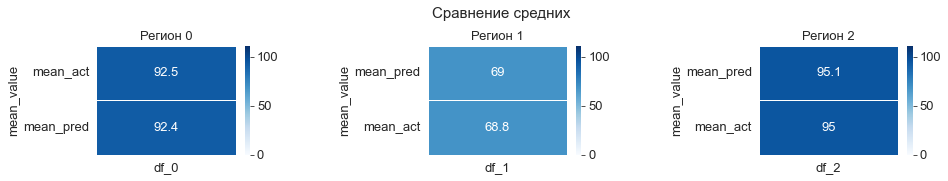

In [24]:
df_list = ['df_0', 'df_1', 'df_2']
ax_list = ['ax1', 'ax2', 'ax3']
title_list = ['Регион 0', 'Регион 1', 'Регион 2']

fig, (ax1,ax2,ax3) = plt.subplots(ncols=3, figsize=(15,2))
fig.subplots_adjust(wspace=0.9)
fig.suptitle('Сравнение средних', y = 1.15, fontsize = 15)

for i in range(3):
    sns.heatmap(compare_mean[['mean_value', df_list[i]]].set_index('mean_value').sort_values(by=df_list[i], ascending=False),
                ax=locals()[ax_list[i]],
                cmap="Blues",
                annot=True,
                fmt ='.3g',
                annot_kws={'size':13},
                vmin=0, vmax=product_plus,
                linewidths=.5);
    
    locals()[ax_list[i]].tick_params(rotation=0)
    locals()[ax_list[i]].set_title(title_list[i], fontsize=13);

- Средний запас предсказанного сырья соизмерим с текущим средним запасом в каждом регионе,<br />поэтому правомерно сравнить полученный объём сырья со средним запасом предсказанного сырья.

In [25]:
compare_metrics

region  mean_pred    rmse  rmse_const  sanity     r2     mae
0  reg_0     92.424  37.717      44.347    True  0.277  31.109
1  reg_1     68.983   0.891      45.970    True  1.000   0.718
2  reg_2     95.116  39.976      44.575    True  0.196  32.777

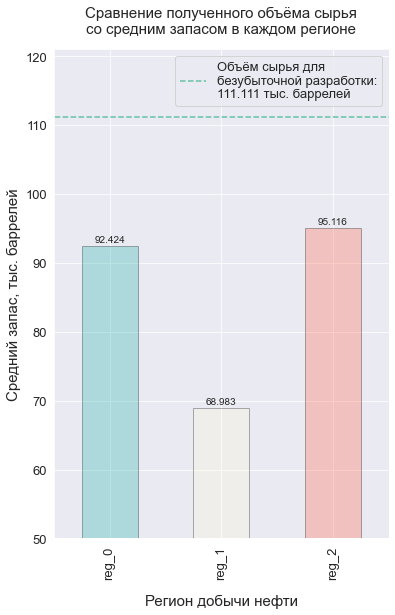

In [26]:
fig, ax = plt.subplots(figsize=(6,9))

plt.title('Сравнение полученного объёма сырья\nсо средним запасом в каждом регионе', fontsize=15, y=1.02)

plot_1=compare_metrics.plot(kind='bar',
                            x='region',
                            y='mean_pred',
                            ec='black',
                            ax=ax,
                            width=0.5,
                            color=['lightseagreen', 'cornsilk', 'tomato'],
                            fontsize=13,
                            alpha=0.3,
                            ylim=(50, 121))

plot_1.bar_label(ax.containers[0], padding=2, fontsize=10)

plot_2 = plt.plot([-1, 3], [product_plus, product_plus],
                  linestyle='--',
                  label=f'Объём сырья для\nбезубыточной разработки:\n{round(product_plus, 3)} тыс. баррелей')

plt.legend(handles=[plot_2[0]])
plt.xlabel('Регион добычи нефти', fontsize= 15, labelpad = 15)    
plt.ylabel('Средний запас, тыс. баррелей', fontsize=15);

### Выводы по этапу подготовки расчёта прибыли

Объём сырья, достаточный для безубыточной разработки новой скважины ${product_{plus}} = {\mathcal {111.111\,тыс. баррелей}}$

Во всех регионах средние показатели убыточны.

## Функция для расчёта прибыли по выбранным скважинам и предсказаниям модели

### Анализ скважин с максимальными значениями предсказаний

В исходных данных указано отобрать 200 лучших. Сделаем это.

In [27]:
best_marks_0 = marks_valid_0.sort_values(by='predicted_valid', ascending=False).head(200).sort_index(ignore_index=True)
best_marks_1 = marks_valid_1.sort_values(by='predicted_valid', ascending=False).head(200).sort_index(ignore_index=True)
best_marks_2 = marks_valid_2.sort_values(by='predicted_valid', ascending=False).head(200).sort_index(ignore_index=True)

Посмотрим графически на показатели отобранных скважин.<br>Cравним с объёмом сырья, достаточным для безубыточной разработки новой скважины.

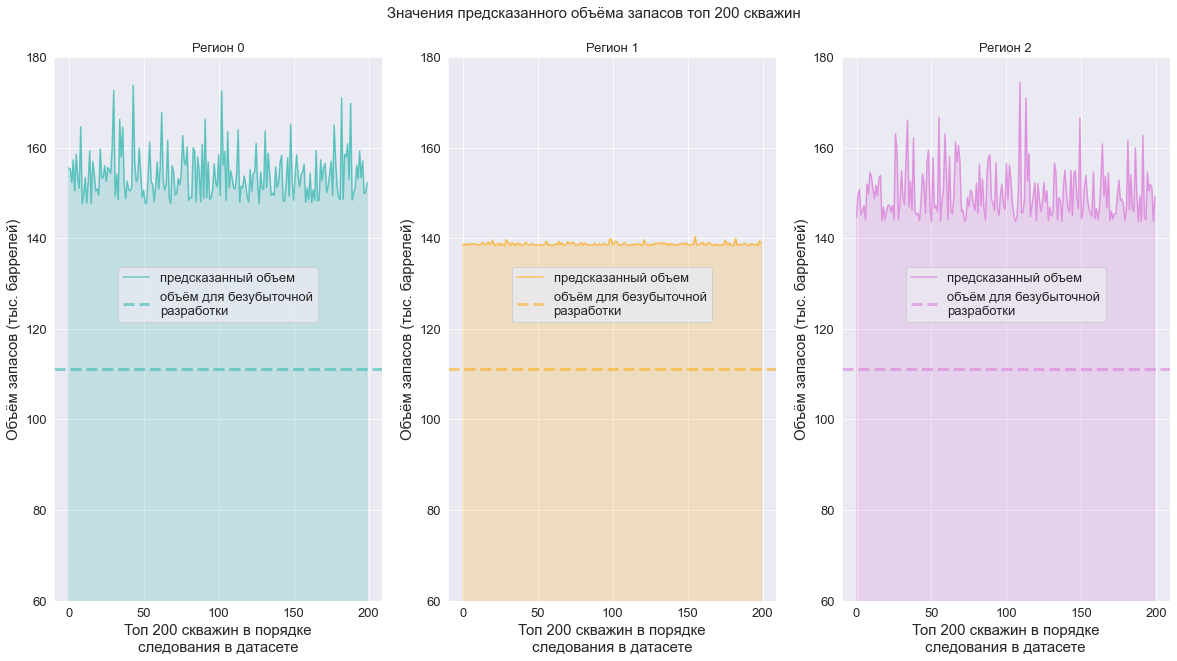

In [28]:
fig, (ax1,ax2,ax3) = plt.subplots(ncols=3, figsize=(20,10))
fig.subplots_adjust(wspace=0.2)
fig.suptitle('Значения предсказанного объёма запасов топ 200 скважин', y = .95, fontsize = 15)

for df, color, axis, title in zip([best_marks_0, best_marks_1, best_marks_2],
                                  ['lightseagreen', 'orange', 'orchid'],
                                  [ax1, ax2, ax3],
                                  ['Регион 0', 'Регион 1', 'Регион 2']):

    df.plot(y='predicted_valid',
            use_index=True,
            color=color,
            alpha=0.6,
            ax=axis,                  
            ylim=(60,180))
    
    axis.axhline(product_plus,
                 color=color,
                 linewidth=3,
                 linestyle="--",
                 alpha=.5)
    
    axis.fill_between(df.index, df['predicted_valid'], color=color, alpha=0.2)
    

    
    axis.set_title(title, fontsize=13);
    
    axis.set_xlabel('Топ 200 скважин в порядке\nследования в датасете', fontsize=15)
    axis.set_ylabel('Объём запасов (тыс. баррелей)', fontsize=15)
    axis.legend(['предсказанный объем', 'объём для безубыточной\nразработки'],
                 loc='lower center',
                 bbox_to_anchor=[0.5, 0.5])

Для всех трех регионов показатели отобранных скважин выше объёма сырья, достаточного для безубыточной разработки новой скважины.

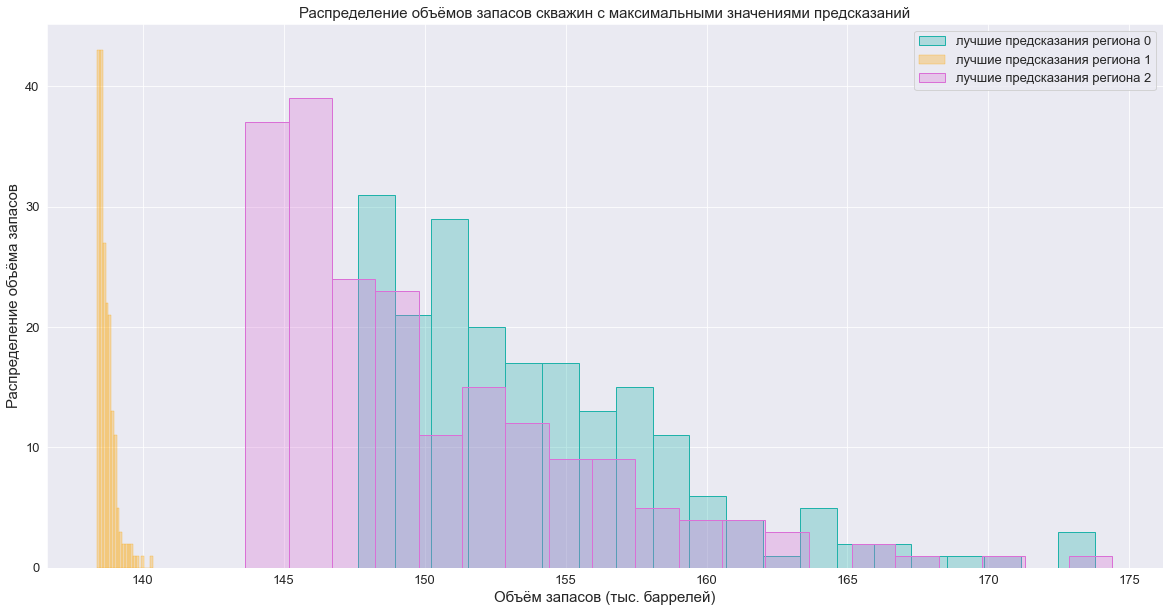

In [29]:
fig, ax = plt.subplots(figsize=(20,10))

for data, title, color in zip([best_marks_0, best_marks_1, best_marks_2],
                              ['Регион_0', 'Регион_1', 'Регион_2'],
                              ['lightseagreen', 'orange', 'orchid']):                                 
    
    histplot = sns.histplot(data=data,
                            x='predicted_valid',
                            bins=20,
                            color=color,
                            edgecolor=color,
                            fill=True,
                            alpha=.3)  

plt.title('Распределение объёмов запасов скважин с максимальными значениями предсказаний', fontsize=15)
plt.legend(['лучшие предсказания региона 0',
            'лучшие предсказания региона 1',
            'лучшие предсказания региона 2'])
plt.xlabel('Объём запасов (тыс. баррелей)', fontsize=15)
plt.ylabel('Распределение объёма запасов', fontsize=15);

- Все распределения далеки от нормального - с аномально высоким краем, это наблюдается т.к. по факту мы отрезали как раз левую часть данных, оставив правую, выбирая запасы с максимальными значениями предсказаний. Для региона 0 и 2 более плавное распределение слева направо, т.к. по анализу выше наблюдалось нормальное распределение до выбора топ 200. Для региона 1 нормальное распрделение не наблюдалось и до выбора топ 200.

- Объем запасов региона региона 1 заметно уступает остальным.

### Функция расчёта прибыли

Прибыль для полученного объёма сырья расчитаем по формуле:

$ \large profit = (\sum_{i=1}^{count}target)\cdot revenue_{product}-budget $

где:
- `profit` - прибыль для полученного объёма сырья, (руб)
- `target` - целевое значение объёма сырья, соответствующее предсказаниям с максимальными значениями, (тыс. баррелей)
- `revenue_product` - доход с каждой единицы продукта, (руб)
- `budget` - бюджет на разработку, (руб)

Создадим функцию `revenue` для расчёта прибыли по выбранным скважинам и предсказаниям модели, на вход которой подаётся:
- `target` - правильные ответы
- `probabilities` - предсказания
- `count` - количество максимальных значений предсказаний

На выходе функции:
- `profit` - прибьль

In [30]:
def revenue(target, predicted, count):
    '''Выбор скважин с максимальными значениями предсказаний'''
    pred_sorted = predicted.sort_values(ascending=False)
    '''Просуммируем целевое значение объёма сырья, соответствующее предсказаниям'''
    selected = target[pred_sorted.index][:count].sum()
    '''Рассчёт прибыли для полученного объёма сырья'''
    profit = (selected.sum()*revenue_product - budget).round(3)
    '''Определение параметров на выходе функции'''
    return profit

### Расчёт прибыли для полученного объёма сырья

Для расчёта прибыли для полученного объёма сырья применим ранее написанную функцию `revenue` и сохраним результаты в датасет `revenue_top_200`:
- `region` - наименование региона
- `revenue` - прибыль, руб
- `revenue_milliard` - та же прибыль, но единица изменерия млрд руб

In [31]:
revenue_top_200 = pd.DataFrame({'region': ['reg_0','reg_1','reg_2'],
                                'revenue': [revenue(marks_valid_0['target_valid'], marks_valid_0['predicted_valid'], 200),
                                            revenue(marks_valid_1['target_valid'], marks_valid_1['predicted_valid'], 200),
                                            revenue(marks_valid_2['target_valid'], marks_valid_2['predicted_valid'], 200)]})
revenue_top_200['revenue_milliard'] = (revenue_top_200['revenue']/10**9).map('{:,.3f}'.format).astype(np.float64)
revenue_top_200.set_index('region')

revenue  revenue_milliard
region                                
reg_0   3.136026e+09             3.136
reg_1   2.415087e+09             2.415
reg_2   2.465946e+09             2.466

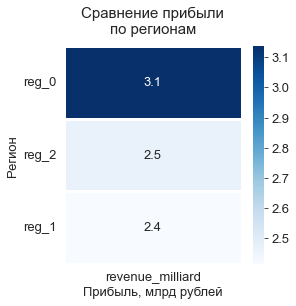

In [32]:
fig, ax = plt.subplots(figsize=(4,4))

sns.heatmap(revenue_top_200[['region','revenue_milliard']].set_index('region').sort_values(by='revenue_milliard', ascending=False),
            ax=ax,
            cmap="Blues",
            annot=True,
            annot_kws={'size':13},
            linewidths=2.5).set(xlabel = 'Прибыль, млрд рублей',
                                ylabel = 'Регион');

ax.tick_params(rotation=0)
ax.set_title('Сравнение прибыли\nпо регионам', y = 1.03, fontsize = 15);

## Расчёт рисков и прибыли для каждого региона

- После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.

### Техника Bootstrap и опредение бизнес-метрик

Применим технику Bootstrap с 1000 выборок, чтобы найти распределение прибыли.

Создадим функцию `bootstrap()`,

принимающую на вход:
- `marks_valid` - датасет с целевым признаком и предсказаниями валидационной выборки:
- `name` - имя региона

На выходе функции - датасет с бизнез-метриками:
- `region` - наименование региона
- `revenue_mean` - средняя прибыль, руб
- `.025_quantile` - 0.025-квантиль, руб
- `.975_quantile` - 0.975-квантиль, руб
- `risk` - вероятность убытков, %

In [33]:
def bootstrap(marks_valid: pd.DataFrame, name: str):
    
    '''техника Bootstrap с 1000 выборок для получения распределение прибыли'''
    state = np.random.RandomState(12345)    
    revenues = []
    for i in range(1000):
        
        '''формирование выборки из ответов для 500 точек'''
        target_subsample = marks_valid['target_valid'].sample(n=500, replace=True, random_state=state)
        
        '''извлечение предсказаний с одними и теми же индексами, что у ответов'''
        pred_subsample = marks_valid['predicted_valid'][target_subsample.index]
        
        '''формирование списка прибылей из бутстрепа в переменной для 200 лучших для разработки точек'''
        revenues.append(revenue(target_subsample, pred_subsample, 200))
    revenues = pd.Series(revenues)
    
    '''средняя прибыль'''
    revenue_mean = revenues.mean()
    
    '''95%-й доверительный интервал'''
    '''Сохранение .025 и .975 квантилей  в переменных'''
    lower = revenues.quantile(.025)
    upper = revenues.quantile(.975)
    confidence_interval = [lower, upper]
    
    '''Риск убытков'''
    risk = (revenues<0).mean()
    
    print(f'Средняя прибыль: {revenue_mean:,.0f} руб')
    print(f'95% доверительный интервал: [{lower:,.0f}; {upper:,.0f}] руб')
    print(f'Риск убытков: {risk:.1%}')

    return pd.DataFrame({'region': name,
                         'revenue_mean': [revenue_mean],
                         '.025_quantile': [lower],
                         '.975_quantile': [upper],
                         'risk': risk})

#### Регион 0

In [34]:
bootstrap_0=bootstrap(marks_valid_0, 'reg_0')

Средняя прибыль: 459,085,613 руб
95% доверительный интервал: [-90,234,067; 987,953,883] руб
Риск убытков: 4.7%


#### Регион 1

In [35]:
bootstrap_1=bootstrap(marks_valid_1, 'reg_1')

Средняя прибыль: 535,246,952 руб
95% доверительный интервал: [86,681,038; 958,082,040] руб
Риск убытков: 1.4%


#### Регион 2

In [36]:
bootstrap_2=bootstrap(marks_valid_2, 'reg_2')

Средняя прибыль: 351,243,818 руб
95% доверительный интервал: [-174,807,393; 879,066,224] руб
Риск убытков: 11.4%


### Сравнение результатов

Сведем полученные ранее бизнес-метрики для всех регионов в один датасет `compare_bootstrap`:
- `region` - наименование региона
- `revenue_mean` - средняя прибыль, руб
- `.025_quantile` - 0.025-квантиль, руб
- `.975_quantile` - 0.975-квантиль, руб
- `risk` - вероятность убытков, %
- `revenue_million` - та же средняя прибыль, но единица изменерия миллион руб

In [37]:
compare_bootstrap = (bootstrap_0.merge(bootstrap_1, on=list(bootstrap_0.columns), how='outer')
                                .merge(bootstrap_2, on=list(bootstrap_0.columns), how='outer'))

compare_bootstrap['revenue_million'] = (compare_bootstrap['revenue_mean']/10**6).map('{:,.3f}'.format).astype(np.float64)

compare_bootstrap.set_index('region')

revenue_mean  .025_quantile  .975_quantile   risk  revenue_million
region                                                                    
reg_0   4.590856e+08  -9.023407e+07   9.879539e+08  0.047          459.086
reg_1   5.352470e+08   8.668104e+07   9.580820e+08  0.014          535.247
reg_2   3.512438e+08  -1.748074e+08   8.790662e+08  0.114          351.244

Сравним тепловые карты бизнес-метрик регионов

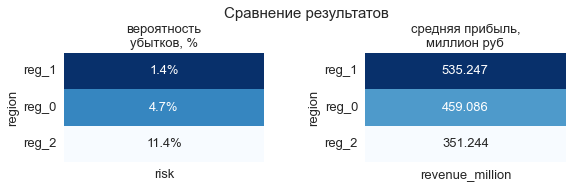

In [38]:
fig, (ax1,ax2) = plt.subplots(ncols=2, figsize=(9,2))
 
fig.subplots_adjust(wspace=0.5)
fig.suptitle('Сравнение результатов', y = 1.2, fontsize = 15)

axis = [ax1, ax2]
metric = ['risk','revenue_million']
sorting = [True, False]
color = ['Blues_r','Blues']
fmt = ['.1%','.3f']
title = ['вероятность\nубытков, %','средняя прибыль,\nмиллион руб']

for i in range(2):
    sns.heatmap(compare_bootstrap[['region', metric[i]]].set_index('region').sort_values(by=metric[i], ascending=sorting[i]),
                ax=axis[i],
                cbar=False,
                cmap=color[i],
                annot=True,
                fmt=fmt[i],
                annot_kws={'size':13})
    axis[i].tick_params(rotation=0)
    axis[i].set_title(title[i], fontsize=13);

По исходным данным от заказчика требуется оставить лишь те регионы, в которых вероятность убытков меньше 2.5%, и среди них выбрать регион с наибольшей средней прибылью.

Перечисленным требованиям удовлетворяет регион 1.

## Вывод

| <font size="4"><center>По результатам исследования EDA и выполнения ML рекомедуется:</center></font> |
| :---: |
|<font size="3">Бурить новую скважину в регионе 1 (второй в списке),<br>т.к. в данном регионе минимальная вероятность убытков с максимальной средней прибылью.|